# Task 1
We start by reading the data and plotting it.

In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.layers import *

C:\Users\aujo8\AppData\Local\Temp\ipykernel_11976\2946572245.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("Temperature_Anomaly_1880_2021.txt", header=None, delim_whitespace=True)


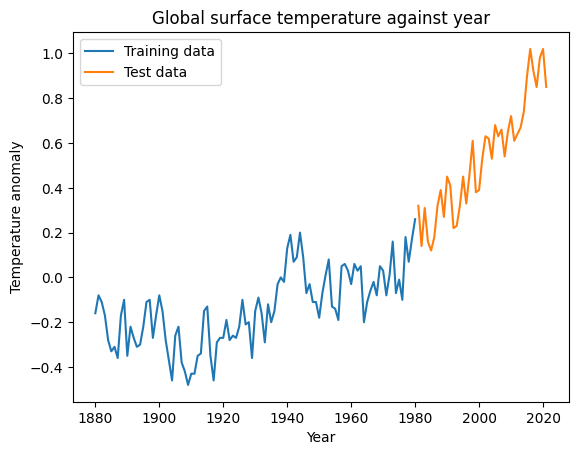

In [6]:
df = pd.read_csv("Temperature_Anomaly_1880_2021.txt", header=None, delim_whitespace=True)
df.columns = ["year", "temp"]

# make sure data is sorted by year
df = df.sort_values(by='year')

# split data into training (1880-1980) and test (1981-2021)
train_origi = df.query('year < 1981').reset_index(drop=True)
test_origi = df.query('year > 1980').reset_index(drop=True)

plt.plot(train_origi["year"], train_origi["temp"], label="Training data")
plt.plot(test_origi["year"], test_origi["temp"], label="Test data")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly")
plt.title("Global surface temperature against year")
plt.legend()

This is not a stationary time-series and we therefore resort to transforming our variables to $$y(t) = x(t) - x(t-1)$$ as recommended in the description of the project. This leads to reduing the size of the training data by 1 as there is no way of creating a difference for the first data point. 

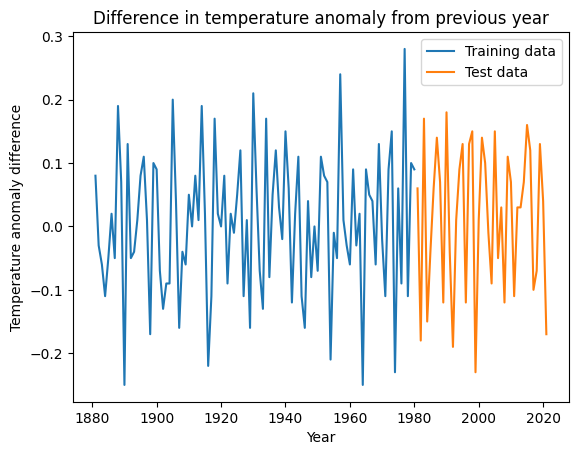

In [8]:
# constructing the temperature difference time-series y(t)
temp_diff = [df["temp"][i] - df["temp"][i-1] for i in range(1, len(df["temp"]))]
year = df["year"][1:]
dict_diff = {'year':year, 'temp_diff':temp_diff}
df_diff = pd.DataFrame(dict_diff)

# create new training, test data
train = df_diff.query('year < 1981').reset_index(drop=True)
test = df_diff.query('year > 1980').reset_index(drop=True)

plt.plot(train["year"], train["temp_diff"], label="Training data")
plt.plot(test["year"], test["temp_diff"], label="Test data")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly difference")
plt.title("Difference in temperature anomaly from previous year")
plt.legend()

This looks more stationary and as such we will use the previosuly defined $y(t)$ as response variable. For the predictors we use a sequence of the $\tau$ previous temperature differences, i.e. $$\{ y(t-\tau-1),\ldots, y(t-1) \},$$ for some integer $\tau$ which we will most likely have to tune in order to find a good model. This response-predictor relationship holds for all $t\geq \tau+1$.

# Task 2
Description of RNN architecture:
 - number of time steps $\tau=5$,
 - number of input units, following $\tau$, is also 5,
 - number of hidden units per LSTM layer: 12, 
 - layers: two LSTM layers, each one followed by a dropout layer (5 %), and one fully connected output layer at the end,
 - LSTM activations: $\tanh$ for the cell state, and $\sigma$ (sigmoid) for the input, forget and output gates
 - Output layer activation: None (or linear)
 - Loss function: MSE

Most the above resulted from tuning the settings given in the blogpost provided in the project description. The rest, like the activation functions used in the LSTM were copied directly from the lectures.

As this model takes a sequence of 5 time steps as input and returns one value as output (the predicted temperature difference on day $t$), this is a **many-to-one** architecture.

See model summary below the next code chunk.

In [95]:
# length j of time-sequence acting as predictor
tau = 5 # will most likely need some tuning

# split training and test data into predictors and targets based on j
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(tau, len(train['year'])):
    # training data
    X_train.append(train["temp_diff"][i-tau : i])
    y_train.append(train["temp_diff"][i])

for i in range(tau, len(test['year'])):
    # test data
    X_test.append(test["temp_diff"][i-tau : i])
    y_test.append(test["temp_diff"][i])

# making into np arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# model architecture
model = Sequential(
    [
        # the input to the model
        Input((X_train.shape[1], 1)),
        
        # first LSTM layer
        LSTM(units=12, return_sequences=True),
        Dropout(0.05),

        # second LSTM layer
        LSTM(units=12, return_sequences=False),
        Dropout(0.05),

        # output layer
        Dense(units=1)
    ]
    
)

# summary of the model
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 5, 12)          │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 5, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 12)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,885 (7.36 KB)

 Trainable params: 1,885 (7.36 KB)

 Non-trainable params: 0 (0.00 B)

# Task 3
In this task we train the model.

In [96]:
# compiling the model and choosing loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=8)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - val_loss: 0.0125
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - val_loss: 0.0125
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

Using the model to predict on the test data, and transforming back to original space.

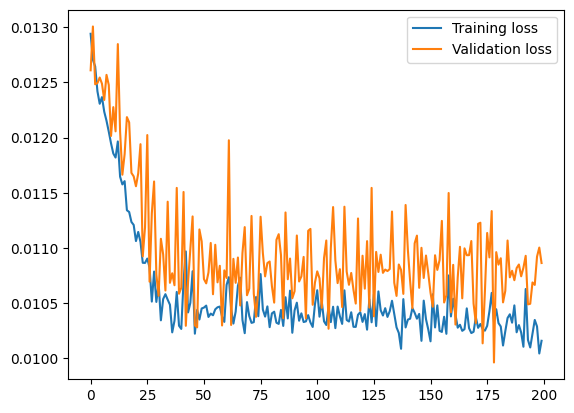

In [97]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.show()

From the above training/validation plot we are inclined to say that the training looks healthy enough. The training seems to converge and the validation is not very far off. There are, of course, what looks to be heavy fluctuations in especially the validation curve. The sizes of these fluctuations seem to lie around $0.05$ of which the square root (since we are using MSE) is $\approx 0.20$, which, if we look to the span of the temperature differences in one of the previous plots, we can see that this is a significant fluctuation. However, since we are working with time series analysis, we are mainly interested if we are able to match the trend, and not so much each individual value. This, we will further examine in the next task.

# Task 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


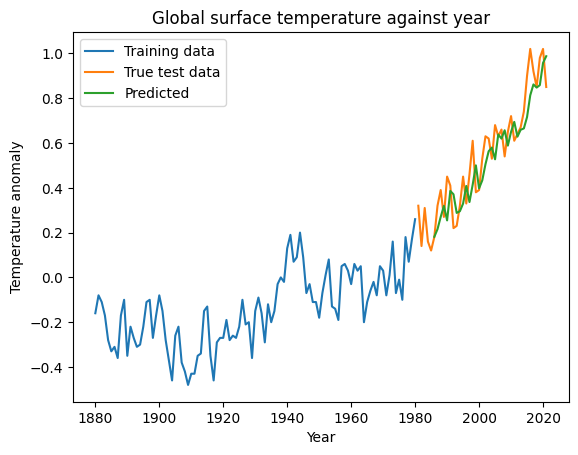

In [99]:
# precitions made from the test set
pred = model.predict(X_test)

# transformin the differences back to original space
pred_origi = [pred[t-j] + test_origi["temp"][t-1] for t in range(j, len(test))]

plt.plot(train_origi["year"], train_origi["temp"], label="Training data")
plt.plot(test_origi["year"], test_origi["temp"], label="True test data")
plt.plot(test_origi["year"][j:], pred_origi, label="Predicted")
plt.xlabel("Year")
plt.ylabel("Temperature anomaly")
plt.title("Global surface temperature against year")
plt.legend()

From the above plot, our model seems to have captured the trend of the test data pretty well. It is of a bit lower variance than the true data with its less extreme spikes, especially "upwards". In this sense, our predictions are a bit on the conservative side.

One of the reasons for the model having been able to capture the trend of the temperature increase well is that we have been using long short-term memory in our model. These are improvements on the regular RNN architecture (where vanishing/exploding gradients are a problem) in order to capture both long and short term dependencies well.

The input gates decide which information should be allowed to enter the model, the forget gates allow for discarding useless information and the output gates decide what parts of history should be allowed to contribute to the output (and in what scale). Together, these three allows for short-term fluctuations and long-term dependencies at the same time - which exactly what we aim to do when modeling time series data. 